## Dataset loading

In [1]:
from pathlib import Path

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

from seiz_eeg.dataset import EEGDataset
import torch.optim as optim

from torch.utils.data import DataLoader
from tqdm import tqdm

import sys

sys.path.append("/home/stnikoli/nml_project/GAT")

In [ ]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/stnikoli/nml_project/data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42, shuffle=True)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

# split the clips into training and validation sets
# train_clips, val_clips = train_test_split(clips_tr, test_size=0.2, random_state=42)

In [3]:

from hjorth_features import create_hjorth_transforms

_hjorth_transform, _ = create_hjorth_transforms()

In [4]:
def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

In [5]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=_hjorth_transform,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=_hjorth_transform,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=512,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

In [6]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [7]:
# count ones and zeros in the training set
ones_count = np.sum([x[1] for x in train_dataset])
zeros_count = len(train_dataset) - ones_count
print(f"Ones count: {ones_count}, Zeros count: {zeros_count}")

Ones count: 2004, Zeros count: 8390


## New implementation

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

import numpy as np
from pathlib import Path
from tqdm import tqdm
from torch.utils.data import DataLoader

# Assume DATA_ROOT, _hjorth_transform, train_clips, and val_clips are defined
# Assume device is also defined (e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# ======================================================================
# 1. Refined GAT Model Definition
#    - The forward method now correctly accepts edge_index and batch.
#    - The model no longer stores the adjacency matrix, simplifying its design.
#    - The output dimension is set to 1, which is correct for BCEWithLogitsLoss.
# ======================================================================

class GATClassifier(nn.Module):
    def __init__(self, num_node_features, num_classes=1):
        super(GATClassifier, self).__init__()
        
        # GAT layers
        self.conv1 = GATConv(num_node_features, 32, heads=4, dropout=0.5)
        self.conv2 = GATConv(32 * 4, 64, heads=4, dropout=0.5)
        
        # Pooling and final classification layer
        self.pool = global_mean_pool
        self.fc = nn.Linear(64 * 4, num_classes)

    def forward(self, x, edge_index, batch):
        # The edge_index is now passed directly here
        x = F.elu(self.conv1(x, edge_index))
        x, attention_weights = self.conv2(x, edge_index, return_attention_weights=True)
        
        x = self.pool(x, batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc(x)
        
        return x, attention_weights


In [9]:
# ======================================================================
# 2. Streamlined Graph Creation
#    - This single function now handles loading distances and creating the
#      sparse `edge_index` directly, removing redundant steps.
# ======================================================================

def create_graph_edge_index(distances_path, distance_threshold=None):
    """
    Loads electrode distances and creates a sparse graph edge_index.
    """
    # Load distance matrix, assuming 19 electrodes
    distances = np.genfromtxt(distances_path, skip_header=1, delimiter=',')[:, -1].reshape(19, 19)
    distances = torch.tensor(distances, dtype=torch.float32)
    
    if distance_threshold is None:
        # Use an adaptive threshold based on the median distance
        distance_threshold = torch.median(distances[distances > 0])
    
    # Create adjacency matrix and convert directly to edge_index
    adj_matrix = (distances <= distance_threshold)
    edge_index = adj_matrix.nonzero(as_tuple=False).t().contiguous()
    
    return edge_index

In [10]:
# ======================================================================
# 3. Training Loop (Unchanged, as it was already correct)
# ======================================================================

def train_epoch(model, train_loader, criterion, optimizer, device, single_graph_edge_index):
    """Train the model for one epoch using a standard DataLoader."""
    model.train()
    total_loss = 0.0
    
    edge_index_template = single_graph_edge_index.to(device)

    for x_batch, y_batch in tqdm(train_loader, desc="Training", leave=False):
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().unsqueeze(1).to(device)
        
        B, N, F = x_batch.shape

        # --- On-the-fly Batch Conversion ---
        x_pyg = x_batch.reshape(-1, F)
        batch_vector = torch.arange(B, device=device).repeat_interleave(N)
        edge_indices = [edge_index_template + i * N for i in range(B)]
        batched_edge_index = torch.cat(edge_indices, dim=1)
        # --- Conversion Complete ---

        optimizer.zero_grad()
        # This call now matches the corrected GATClassifier.forward signature
        logits, _ = model(x_pyg, batched_edge_index, batch_vector)
        loss = criterion(logits, y_batch)
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(train_loader)



In [11]:
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([1], device=device))
criterion(torch.tensor([0.0, 0.0, 0.0, 0.0], device=device), torch.tensor([1.0, 1.0, 1.0, 1.0], device=device))

tensor(0.6931, device='cuda:0')

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

def test_epoch(model, test_loader, criterion, device, single_graph_edge_index):
    """Evaluate the model on the test set for one epoch."""
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    
    all_preds = []
    all_labels = []
    all_ids = []

    # Move the single-graph edge_index to the correct device once
    edge_index_template = single_graph_edge_index.to(device)

    with torch.no_grad():  # Deactivate autograd for evaluation
        for x_batch, y_batch in tqdm(test_loader, desc="Testing", leave=False):
            # x_batch shape: (batch_size, num_nodes, num_features)
            # y_batch shape: (batch_size)
            
            x_batch = x_batch.float().to(device)
            y_batch_labels = y_batch.float() # Keep labels on CPU for sklearn
            y_batch_loss = y_batch_labels.unsqueeze(1).to(device) # Send to device for loss calc
            
            B, N, F = x_batch.shape # Batch size, Num nodes, Num features

            # --- On-the-fly Batch Conversion (same as in train_epoch) ---
            x_pyg = x_batch.reshape(-1, F)
            batch_vector = torch.arange(B, device=device).repeat_interleave(N)
            edge_indices = [edge_index_template + i * N for i in range(B)]
            batched_edge_index = torch.cat(edge_indices, dim=1)
            # --- Conversion Complete ---

            # Forward pass
            logits, _ = model(x_pyg, batched_edge_index, batch_vector)
            loss = criterion(logits, y_batch_loss)
            
            total_loss += loss.item()

            # --- Calculate Predictions for Metrics ---
            # Apply sigmoid to logits to get probabilities
            probs = torch.sigmoid(logits).cpu()
            # Get binary predictions (0 or 1) using a 0.5 threshold
            preds = (probs > 0.5).float().squeeze(1)
            
            # Append batch results to lists for epoch-wide calculation
            all_preds.extend(preds.numpy())
            all_labels.extend(y_batch_labels.numpy())
            all_ids.extend(y_batch.numpy())

    # Calculate metrics for the entire epoch
    avg_loss = total_loss / len(test_loader)
    f1 = f1_score(all_labels, all_preds, zero_division=0, average='macro')
    precision = precision_score(all_labels, all_preds, zero_division=0)
    recall = recall_score(all_labels, all_preds, zero_division=0)
    
    return avg_loss, f1, precision, recall, all_preds, all_labels, all_ids

In [14]:
# Instantiate the simplified model
model = GATClassifier(num_node_features=15, num_classes=1) # num_classes=1 for BCEWithLogitsLoss

# Or load a pre-trained model if available
# model.load_state_dict(torch.load("/home/stnikoli/nml_project/GAT/gat_model_epoch_300.pth"))
model = model.to(device)

In [15]:
# ======================================================================
# 4. Main Execution Block
# ======================================================================

# --- Graph and Model Setup ---
# Create the single graph structure ONCE
single_graph_edge_index = create_graph_edge_index(
    distances_path=DATA_ROOT / "distances_3d.csv",
    distance_threshold=None
)


# --- Training Setup ---
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([class_weight], device=device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)


# --- Training Loop ---
num_epochs = 1000
train_losses = []
val_losses = []

print("Starting training...")
for epoch in range(num_epochs):    
    train_loss = train_epoch(model, loader_tr, criterion, optimizer, device, single_graph_edge_index)
    
    train_losses.append(train_loss)
    if (epoch + 1) % 50 == 0:
        print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")
        # Validation
        val_loss, f1, precision, recall, _, _, _ = test_epoch(model, loader_val, criterion, device, single_graph_edge_index)
        print(f"Epoch {epoch + 1}, Val Loss: {val_loss:.4f}, F1: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
        val_losses.append(val_loss)

    # save model every 100 epochs
    if (epoch + 1) % 100 == 0:
        torch.save(model.state_dict(), f"/home/stnikoli/nml_project/GAT/gat_model_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")

print("Training finished.")

Starting training...


Training:   0%|                                                                                                                                                                                                                               | 0/21 [00:00<?, ?it/s]

Epoch 50, Train Loss: 490.2186


Epoch 50, Val Loss: 418.8478, F1: 0.2030, Precision: 0.1841, Recall: 0.2261


Epoch 100, Train Loss: 345.2811


Epoch 100, Val Loss: 321.3082, F1: 0.1957, Precision: 0.1946, Recall: 0.1969
Model saved at epoch 100


Epoch 150, Train Loss: 170.8298


Epoch 150, Val Loss: 105.0590, F1: 0.2405, Precision: 0.2543, Recall: 0.2281


Epoch 200, Train Loss: 136.1449


Epoch 200, Val Loss: 66.0134, F1: 0.2547, Precision: 0.4178, Recall: 0.1832
Model saved at epoch 200


Epoch 250, Train Loss: 101.9592


Epoch 250, Val Loss: 44.9989, F1: 0.3396, Precision: 0.4722, Recall: 0.2651


Epoch 300, Train Loss: 46.8667


Epoch 300, Val Loss: 26.8666, F1: 0.3750, Precision: 0.5424, Recall: 0.2865
Model saved at epoch 300


Epoch 350, Train Loss: 27.8497


Epoch 350, Val Loss: 26.8866, F1: 0.4359, Precision: 0.5420, Recall: 0.3645


Epoch 400, Train Loss: 36.1797


Epoch 400, Val Loss: 24.4087, F1: 0.4182, Precision: 0.5401, Recall: 0.3411
Model saved at epoch 400


Epoch 450, Train Loss: 10.4980


Epoch 450, Val Loss: 40.4540, F1: 0.3912, Precision: 0.5758, Recall: 0.2963


Epoch 500, Train Loss: 10.1133


Epoch 500, Val Loss: 41.2185, F1: 0.3634, Precision: 0.5870, Recall: 0.2632
Model saved at epoch 500


Epoch 550, Train Loss: 31.5891


Epoch 550, Val Loss: 25.0459, F1: 0.3929, Precision: 0.5683, Recall: 0.3002


Epoch 600, Train Loss: 5.5322


Epoch 600, Val Loss: 25.0224, F1: 0.3846, Precision: 0.5618, Recall: 0.2924
Model saved at epoch 600


Epoch 650, Train Loss: 6.2394


Epoch 650, Val Loss: 13.0427, F1: 0.4511, Precision: 0.4965, Recall: 0.4133


Epoch 700, Train Loss: 6.8736


Epoch 700, Val Loss: 12.8041, F1: 0.3911, Precision: 0.4897, Recall: 0.3255
Model saved at epoch 700


Epoch 750, Train Loss: 6.1623


Epoch 750, Val Loss: 19.3112, F1: 0.4562, Precision: 0.4899, Recall: 0.4269


Epoch 800, Train Loss: 3.5517


Epoch 800, Val Loss: 24.0859, F1: 0.4879, Precision: 0.3902, Recall: 0.6511
Model saved at epoch 800


Epoch 850, Train Loss: 7.6608


Epoch 850, Val Loss: 22.0625, F1: 0.4575, Precision: 0.4588, Recall: 0.4561


Epoch 900, Train Loss: 2.8173


Epoch 900, Val Loss: 68.6038, F1: 0.4014, Precision: 0.4957, Recall: 0.3372
Model saved at epoch 900


Epoch 950, Train Loss: 4.2492


Epoch 950, Val Loss: 37.3571, F1: 0.3537, Precision: 0.5565, Recall: 0.2593


Epoch 1000, Train Loss: 2.4905


Epoch 1000, Val Loss: 13.2549, F1: 0.3788, Precision: 0.5376, Recall: 0.2924
Model saved at epoch 1000
Training finished.


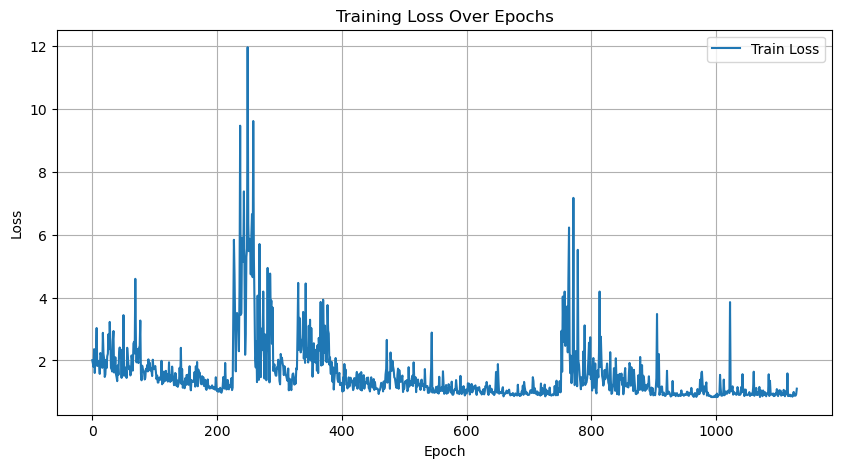

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [46]:
avg_loss, f1, precision, recall, all_preds, all_labels, all_ids = test_epoch(
    model, 
    loader_val, 
    criterion, 
    device, 
    single_graph_edge_index
)

print(f"Validation Loss: {val_loss:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Validation Loss: 1.3052
F1 Score: 0.5499
Precision: 0.5435
Recall: 0.5564


## Submission

In [47]:
test_clips = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [48]:
# Create test dataset
dataset_te = EEGDataset(
    test_clips,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    signal_transform=_hjorth_transform,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [49]:
def generate_submission_file(model, test_loader, single_graph_edge_index, device, output_filename="submission.csv"):
    """
    Generates a Kaggle submission file for the GAT model.

    Args:
        model (nn.Module): The trained GATClassifier model.
        test_loader (DataLoader): DataLoader for the test set. It must yield
                                  batches of (x_batch, ids_batch).
        single_graph_edge_index (torch.Tensor): The pre-computed edge_index for a single graph.
        device (torch.device): The device to run inference on (e.g., 'cuda' or 'cpu').
        output_filename (str): The name of the output CSV file.
    """
    # Set the model to evaluation mode
    model.eval()

    all_predictions = []
    all_ids = []

    # Move the single-graph edge_index to the correct device once
    edge_index_template = single_graph_edge_index.to(device)

    # Disable gradient computation for faster inference
    with torch.no_grad():
        for x_batch, ids_batch in tqdm(test_loader, desc="Generating Submission"):
            # x_batch shape: (batch_size, num_nodes, num_features)
            
            x_batch = x_batch.float().to(device)
            B, N, F = x_batch.shape

            # --- On-the-fly Batch Conversion for GAT model ---
            x_pyg = x_batch.reshape(-1, F)
            batch_vector = torch.arange(B, device=device).repeat_interleave(N)
            edge_indices = [edge_index_template + i * N for i in range(B)]
            batched_edge_index = torch.cat(edge_indices, dim=1)
            # --- Conversion Complete ---

            # Forward pass to get model logits
            # We only need the logits, so we discard the attention weights with `_`
            logits, _ = model(x_pyg, batched_edge_index, batch_vector)

            # Convert logits to binary predictions (0 or 1)
            # A logit > 0 corresponds to a probability > 0.5 after sigmoid
            predictions = (logits > 0).int().cpu().squeeze().tolist()

            # Ensure predictions are in a list, even for a single-item batch
            if not isinstance(predictions, list):
                predictions = [predictions]

            # Store predictions and their corresponding IDs
            all_predictions.extend(predictions)
            all_ids.extend(list(ids_batch))

    # Create a DataFrame for the submission file
    print("Creating submission DataFrame...")
    submission_df = pd.DataFrame({
        "id": all_ids,
        "label": all_predictions
    })

    # Save the DataFrame to a CSV file
    submission_df.to_csv(output_filename, index=False)
    print(f"Submission file saved successfully to: {output_filename}")

In [56]:
# 3. Create the DataLoader for the test set
#    shuffle=False is crucial for submission.
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

# 4. Call the function to generate the file
#    Ensure your model, single_graph_edge_index, and device are defined
generate_submission_file(
    model=model,
    test_loader=loader_te,
    single_graph_edge_index=single_graph_edge_index, # The same one used for training
    device=device,
    output_filename="gat_submission.csv"
)

Generating Submission: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 108.93it/s]

Creating submission DataFrame...
Submission file saved successfully to: gat_submission.csv


In [57]:
# change the gat_submission.csv file lines from p_q_e_j_g_v_e_j___s_0_0_1___t_0_0_0___1_5_7 to pqejgvej_s001_t000_157 format
def format_submission_ids(submission_file):
    """
    Formats the IDs in the submission file to the required format.
    """
    df = pd.read_csv(submission_file)
    
    # Define a function to format each ID
    def format_id(id_str):
        parts = id_str.split("___")
        parts = [part.replace("_", "") for part in parts]
        return "_".join(parts)
    
    # Apply the formatting function to the 'id' column
    df['id'] = df['id'].apply(format_id)
    
    # Save the formatted DataFrame back to CSV
    df.to_csv(submission_file, index=False)
    print(f"Formatted submission file saved successfully to: {submission_file}")

In [58]:
format_submission_ids("gat_submission.csv")

Formatted submission file saved successfully to: gat_submission.csv
